In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision 
import torch.utils.data as Data
from torch.autograd import Variable

npzfile = np.load('cifar10.npz') 
x_train = npzfile['x_train']
x_test  = npzfile['x_test']
y_train = npzfile['y_train']
y_test  = npzfile['y_test']
x_train = x_train.reshape(15000,3*32*32)
x_test  = x_test.reshape(3000,3*32*32)
y_train = y_train[:,0:3]
y_test  = y_test[:,0:3]
y_train = np.argmax(y_train,axis=1)
y_test  = np.argmax(y_test,axis=1)

In [16]:
class myDataSet(torch.utils.data.Dataset):
    def __init__(self,func,train_idx):
        super().__init__()
        self.src = x_train
        self.tag = y_train
        self.idx = np.arange(15000)
        self.train_idx = train_idx
        self.test_idx  = np.setdiff1d(self.idx,self.train_idx)
        self.src = torch.tensor(self.src,dtype=torch.float32)
        self.tag = torch.tensor(self.tag,dtype=torch.int64)
        if func == 'train':
            self.x = self.src[self.train_idx]
            self.y = self.tag[self.train_idx]
        elif func == 'test':
            self.x = self.src[self.test_idx]
            self.y = self.tag[self.test_idx]
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return len(self.x)

In [17]:
class LinearNet(nn.Module):
    def __init__(self,num_classes=3):
        super(LinearNet,self).__init__()
        self.fc1 = nn.Linear(3*32*32,num_classes)
    
    def forward(self,x):
        out = self.fc1(x)
        return out

model = LinearNet()

In [18]:
BATCH_SIZE = 20
train_idx = np.random.choice(np.arange(15000),size=int(15000*0.9),replace=False)
train_dataset = myDataSet(func='train',train_idx=train_idx)
test_dataset  = myDataSet(func='test' ,train_idx=train_idx)
train_loader  = Data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader   = Data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE)

In [19]:
NUM_EPOCHS = 20
LR = 1e-3
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=LR,momentum=0.9, weight_decay=1e-6, nesterov=True)
tr_acc = []
te_acc = []
val_loss_arr = []
for echo in range(NUM_EPOCHS):
    train_loss = 0   
    train_acc = 0   
    model.train()    
    for i,(X,label) in enumerate(train_loader):    
        X = Variable(X)       
        label = Variable(label)
        out = model(X)     
        lossvalue = loss(out,label)         
        optimizer.zero_grad()       
        lossvalue.backward()    
        optimizer.step()          
         
        train_loss += float(lossvalue)   
        _,pred = out.max(1)
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        train_acc += acc
    print("echo:"+' ' + str(echo))
    print("loss:" + ' ' + str(train_loss / len(train_loader)))
    print("TrainACC:" + ' '+str(train_acc / len(train_loader)))
    tr_acc.append(train_acc / len(train_loader))

    eval_acc = 0
    val_loss = 0
    model.eval()
    for i,(X,label) in enumerate(test_loader):
        X = Variable(X)
        label = Variable(label)
        testout = model(X)
        v_loss = float(loss(testout,label))

        _, pred = testout.max(1)
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        eval_acc += acc
        val_loss += v_loss
    print("ValLoss:" + ' ' + str(val_loss / len(test_loader)))
    print('ValACC:' + ' ' + str(eval_acc / len(test_loader)))
    cur_eval_acc = eval_acc/len(test_loader)
    te_acc.append(eval_acc/len(test_loader))
    val_loss_arr.append(val_loss/len(test_loader))

echo: 0
loss: 0.826904882419677
TrainACC: 0.6456190476190482
ValLoss: 0.7537207100126478
ValACC: 0.6982222222222219
echo: 1
loss: 0.7595994632017045
TrainACC: 0.6865714285714284
ValLoss: 0.7275279813342624
ValACC: 0.7151111111111114
echo: 2
loss: 0.7351746017592294
TrainACC: 0.7020000000000006
ValLoss: 0.7571307667096456
ValACC: 0.6882222222222223
echo: 3
loss: 0.726839416367667
TrainACC: 0.7080000000000009
ValLoss: 0.7043871993488736
ValACC: 0.7237777777777775
echo: 4
loss: 0.7115439382053557
TrainACC: 0.7117142857142854
ValLoss: 0.7794076775179969
ValACC: 0.6684444444444442
echo: 5
loss: 0.7020671101411183
TrainACC: 0.7201904761904764
ValLoss: 0.6971045939127604
ValACC: 0.7259999999999998
echo: 6
loss: 0.6977793139503116
TrainACC: 0.7219999999999996
ValLoss: 0.6865743831793467
ValACC: 0.7366666666666667
echo: 7
loss: 0.6969558559145246
TrainACC: 0.7224761904761902
ValLoss: 0.6864551814397176
ValACC: 0.7313333333333332
echo: 8
loss: 0.6870602056526003
TrainACC: 0.7290476190476189
ValL

In [20]:
model.eval()
x_test = torch.tensor(x_test,dtype=torch.float32)
testout = model(x_test)
_, pred = testout.max(1)
pred = np.array(pred)
print('TestAcc:',int((pred == y_test).sum()) / len(pred))

TestAcc: 0.7193333333333334


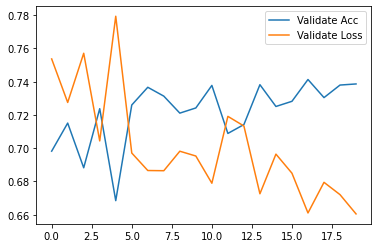

In [21]:
import matplotlib.pyplot as plt
plt.plot(np.arange(NUM_EPOCHS),te_acc,label='Validate Acc')
plt.plot(np.arange(NUM_EPOCHS),val_loss_arr,label='Validate Loss')
plt.legend(loc='best')
plt.show()